# Continuous $paO_2$ Prediction and Postoperative Complications in

Neurosurgical Patients

Preprocessing

Andrea S. Gutmann  
2025-12-16

## 1 Preprocessing

### 1.1 Loading required libraries

In [1]:
# ======================
# Standard library
# ======================
import copy
import csv
import itertools
import os
import pickle
import platform
import pprint
import random
import sys
from collections import Counter, defaultdict
from datetime import datetime, timedelta, timezone
from pathlib import Path
from zoneinfo import ZoneInfo

# ======================
# Third-party libraries
# ======================
import matplotlib
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import session_info
import yaml

# ======================
# scikit-learn
# ======================
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

# ======================
# Configuration & setup
# ======================
pp = pprint.PrettyPrinter(indent=4)
np.random.seed(42)

matplotlib.rcParams["figure.dpi"] = 300
sns.set_style("whitegrid")

with open("./config.yaml", "r") as file:
    config = yaml.safe_load(file)

print(session_info.show(html=False))
print(platform.system())
print(platform.release())

-----
matplotlib          3.10.3
missingno           0.5.2
numpy               2.3.1
pandas              2.3.0
scipy               1.16.0
seaborn             0.13.2
session_info        v1.0.1
sklearn             1.7.0
yaml                6.0.2
-----
IPython             9.3.0
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.4
notebook            7.4.4
-----
Python 3.11.2 (v3.11.2:878ead1ac1, Feb  7 2023, 10:02:41) [Clang 13.0.0 (clang-1300.0.29.30)]
macOS-26.1-arm64-arm-64bit
-----
Session information updated at 2025-12-16 12:42
None
Darwin
25.1.0

### 1.2 Combining dataframes

Function for dataframe statistics

In [2]:
def current_stats(df, p=False):
    """
    Calculate and optionally print summary statistics about a dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The input dataframe containing patient observations.
    p : bool, optional (default=False)
        If True, print a formatted summary message.

    Returns
    -------
    total : int
        Total number of rows (observations) in the dataframe.
    patients : int
        Number of unique patients (based on `identifier` column).
    """
    
    # Total number of rows (observations) in the dataframe
    total = len(df)
    
    # Number of unique patients, assuming 'identifier' uniquely marks each patient
    patients = len(df.identifier.unique())
    
    # Number of rows where paO2 was both measured (flag=1) and has a non-null value
    measured_paO2 = len(df.loc[
        (df.pao2_type_measured == 1) & (df.paO2_measured.notnull()), :
    ])
    
    # If p=True, print a nicely formatted summary of the stats
    if p:
        print(
            f"{total:,} observations from {patients:,} patients "
            f"with {measured_paO2:,} measured paO2 values "
            f"({round(100/total*measured_paO2, 2)} %)."
        )
    
    # Return the total number of rows and unique patients
    return total, patients

Loading data, combining dataframes

In [3]:
with open(config.get("csv").get("one_time_measurements"), "r") as one_time_csv:
    one_time_data = pd.read_csv(one_time_csv)
    one_time_data["sex"] = one_time_data["sex"].apply(lambda x: "female" if x=="w" else "male") 
    one_time_data = pd.get_dummies(one_time_data, columns=["sex"], drop_first=True)
    one_time_data["identifier"] = one_time_data["opid"]
    one_time_data = one_time_data.drop("opid", axis=1)

one_time_data = one_time_data.sort_values(['case_number', 'opdatum'])
one_time_data.drop_duplicates(['case_number', 'opdatum'], inplace=True, ignore_index=True)
display(one_time_data.head())
print(len(one_time_data), len(one_time_data.identifier.unique()))

with open(config.get("csv").get("multi_times_measurements"), "r") as multi_time_csv:
    multi_time_data = pd.read_csv(multi_time_csv, low_memory=False)
    # multi_time_data = multi_time_data.drop("last_horowitz", axis=1)
    multi_time_data['fh_count'] = multi_time_data.groupby('opid')['first_horowitz'].transform(lambda x: x.nunique(dropna=False))
    multi_time_data["identifier"] = multi_time_data["opid"]
    multi_time_data = multi_time_data.drop("opid", axis=1)


display(multi_time_data.head())
print(len(multi_time_data), len(multi_time_data.identifier.unique()))

with open(config.get("pickle").get("selected_features"), "rb") as sf:
    selected_features = [str(s) for s in pickle.load(sf)]
    print(f"Features needed for paO2 prediction: {', '.join(selected_features)}")

# print(
#     f"Starting with {len(multi_time_data):,} observations for {len(multi_time_data.opid.unique()):,} patients with {len(multi_time_data.loc[multi_time_data['paO2_measured'].isnull()==False,:]):,} measured paO2 values ({round(100/len(multi_time_data)*len(multi_time_data.loc[multi_time_data['paO2_measured'].isnull()==False,:]),2)} %)."
# )


# rename intraop_time
one_time_data["incision_closure_time"] = one_time_data["intraop_time"]
one_time_data = one_time_data.drop("intraop_time", axis=1)

# rename rf to respiratory_rate
multi_time_data["respiratory_rate"] = multi_time_data["rf"]
multi_time_data = multi_time_data.drop("rf", axis=1)

# rename mean_art_pressure to mean_art_press
multi_time_data["mean_art_press"] = multi_time_data["mean_art_pressure"]
multi_time_data = multi_time_data.drop("mean_art_pressure", axis=1)

data = multi_time_data.merge(one_time_data, on="identifier")  

data["gadrey"] = ((28.6025) ** 3 / ((1 / (data["spo2"] / 100)) - 0.99)) ** (1 / 3)

data = pd.get_dummies(
    data, columns=["timepoint_of_measurement"]
)  # manually combining timepoints
data["timepoint"] = ""
data.loc[
    data.loc[:, "timepoint_of_measurement_intraoperative"] == 1, "timepoint"
] = "intraoperative"
data.loc[
    data.loc[:, "timepoint_of_measurement_postoperative"] == 1, "timepoint"
] = "postoperative"
data.loc[
    data.loc[:, "timepoint_of_measurement_preoperative"] == 1, "timepoint"
] = "preoperative"
data["timepoint_intraop"] = 0
data.loc[data.loc[:, "timepoint"] == "intraoperative", "timepoint_intraop"] = 1
data = data.drop(["timepoint_of_measurement_intraoperative", "timepoint_of_measurement_postoperative", "timepoint_of_measurement_preoperative", "timepoint"], axis=1)

data.loc[:, "pao2_type_measured"] = 0
data.loc[data["typ"] == "measured", "pao2_type_measured"] = 1
data = data.drop("typ", axis=1)

data['case_number'] = data['case_number'].apply(lambda x:f"00{x}")


print(
    f"Starting with {len(data):,} observations for {len(data.identifier.unique()):,} patients with {len(data.loc[data['paO2_measured'].isnull()==False,:]):,} measured paO2 values ({round(100/len(data)*len(data.loc[data['paO2_measured'].isnull()==False,:]),2)} %)."
)

n1, N1 = current_stats(data)
data = data[data.fh_count==2]
n2, N2 = current_stats(data)
print(f"Removed surgeries were no p/F ratio was measured (N={N1-N2:,}, n={n1-n2:,}).")

display(data.head())

5 rows × 22 columns

7801 7801

5 rows × 24 columns

381430 5565
Features needed for paO2 prediction: idx, co2, spo2, rmv, respiratory_rate, compliance, pAO2, systolic, diastolic, mean_art_press, heart_rate, temperature, ph, hemoglobin, already_intubated, bmi, age, creatinine, gadrey, sex_male, timepoint_intraop, asa
Starting with 381,367 observations for 5,564 patients with 21,667 measured paO2 values (5.68 %).
Removed surgeries were no p/F ratio was measured (N=15, n=690).

5 rows × 46 columns

### 1.3 SAP Procedures

Process SAP procedures

In [4]:
current_stats(data, p=True)

procedures_list = []
main_procedures_list = []
short_procedures_list = []

for proc_long in data.sap_procedures.unique():
    procedures = proc_long.split('|')
    for proc in procedures:
        elements = proc.split("__")
        code = elements[0]
        timestamp = elements[-1]

        for el in elements[1:-1]:
            if len(el) > 1:
                text = el
                break 

        code_short = code.split('.')[0]
        # data.loc[data.sap_procedures == proc_long, code_short] = timestamp

        if code_short not in short_procedures_list:
            short_procedures_list.append(code_short)
        if '__X__' in proc: # wurde bei frühreren Operationen nicht eingetragen
            if f"{code}__{text}" not in main_procedures_list:
                main_procedures_list.append(f"{code}__{text}")
        if f"{code}__{text}" not in procedures_list:
            procedures_list.append(f"{code}__{text}")

config['procedure_codes'] = short_procedures_list

with open('./config.yaml', 'w') as f:
    yaml.safe_dump(config, f, sort_keys = True)

380,677 observations from 5,549 patients with 21,627 measured paO2 values (5.68 %).

Build procedures dictionary

In [5]:
def build_ops_dict(codes):
    groups = defaultdict(list)

    for item in codes:
        code, text = item.split("__", 1)
        key = code.split(".")[0]  # shorten to before period
        groups[key].append(text.strip())

    # Find common text for each group
    result = {}
    for key, texts in groups.items():
        # Split by ": " into hierarchy levels
        split_texts = [t.split(": ") for t in texts]

        # # Find longest common prefix across all variants
        # common = split_texts[0]
        # for t in split_texts[1:]:
        #     i = 0
        #     while i < len(common) and i < len(t) and common[i] == t[i]:
        #         i += 1
        #     common = common[:i]
        commons = Counter(itertools.chain(*split_texts))
        
        # Recombine the common prefix
        result[key] = max(commons, key=commons.get)

    return result

ops_dict = build_ops_dict(procedures_list)

Match procedure per timestamp to surgery

In [6]:
data['intervention_count'] = data.groupby("case_number")["identifier"].transform("nunique")
data[list(ops_dict.keys())] = None

for code in ops_dict.keys():
    data[code] = data['sap_procedures'].apply(lambda x: any([code == entry for entry in x.split('|')]))


### 1.4 Number of surgery during hospital stay

In [7]:
def add_surgery_number(df: pd.DataFrame) -> pd.DataFrame:
    # make sure opdatum is datetime
    df = df.copy()
    df["opdatum"] = pd.to_datetime(df["opdatum"])

    # 1) get earliest date per surgery
    surg_min = (df.groupby("identifier", as_index=False)
                  .agg(case_number=("case_number", "first"),
                       op_min=("opdatum", "min")))

    # 2) assign order within each case_number
    surg_min = (surg_min.sort_values(["case_number", "op_min"])
                         .assign(surgery_number=lambda x: x.groupby("case_number").cumcount() + 1))

    # 3) merge back to original df
    df = df.merge(surg_min[["identifier", "surgery_number"]], on="identifier", how="left")

    df.sort_values(['case_number', 'opdatum'])

    return df

data = add_surgery_number(data)


n1, N1 = current_stats(data, p=True)
data['reop'] = data['surgery_number'] > 1
data = data[data.reop == False]
data = data.drop('surgery_number', axis=1)
n2, N2 = current_stats(data, p=True)
print(f"Remove revision surgeries (N={N1-N2:,}, n={n1-n2:,}).")

380,677 observations from 5,549 patients with 21,627 measured paO2 values (5.68 %).
366,085 observations from 5,253 patients with 20,736 measured paO2 values (5.66 %).
Remove revision surgeries (N=296, n=14,592).

## 2 Exclusion criteria before imputation

In [8]:
# Identify rows where typ == 'measured' and paO2_measured is not missing
measured_mask = (data["pao2_type_measured"] == 1) & data["paO2_measured"].notnull()

print(
    f"Actual average number of ABG per patient: {round(len(data[measured_mask])/len(data[measured_mask].identifier.unique()),2)} in {int(np.mean(data[measured_mask].groupby('identifier')['mv_time'].mean()))} min => one ABG every {int(np.mean(data[measured_mask].groupby('identifier')['mv_time'].mean())/(len(data[measured_mask])/len(data[measured_mask].identifier.unique())))} minutes.\n\n"
)

### negative paO2 values
total, patients = current_stats(data)
missing = len(data[data.paO2_measured.isnull() & (data.pao2_type_measured==1)])
print(f"Missing paO2 values: {missing}")
if missing > 0:
    data = data[~(data.paO2_measured.isnull() & (data.pao2_type_measured==1))]
total2, patients2 = current_stats(data)
print(f"missing paO2 (N={patients-patients2}, n={total-total2})")
data = data[((data.paO2_measured>0) & ((data.pao2_type_measured==1))) | (data.pao2_type_measured==0)]
total3, patients3 = current_stats(data, p=True)
print(f"measured paO2 <= 0 mmHg (N={patients2-patients3}, n={total2-total3:,})\n")


## excluding invalid surgeries ###
print("Excluding invalid surgeries.")

# no length of stay value / negative length of stay
total, patients = current_stats(data)
missing = len(data[data.los.isnull()])
print(f"Missing los data points: {missing}.")
if missing > 0:
    data = data[~(data.los.isnull())]
total2, patients2 = current_stats(data)
print(f"missing LOS (N={patients-patients2}, n={total-total2})")
data = data[data.los>0]
total3, patients3 = current_stats(data, p=True)
print(f"LOS <= 0 days (N={patients2-patients3}, n={total2-total3:,})\n")

# negative time periods
total, patients = current_stats(data)
valid_identifiers = data[(data.time_to_end >= 0)&(data.time_to_incision >= 0)].identifier.unique()
data = data[data.identifier.isin(valid_identifiers)]
total2, patients2 = current_stats(data, p=True)
print(f"time_to_end or time_to_incision < 0 min (N={patients-patients2:,}, n={total-total2:,})\n")

print("\nExcluding based on cut-off values.\n\n")

# 5 min mv or incision to closure times
total, patients = current_stats(data)
valid_identifiers = data[(data.incision_closure_time >= 5)&(data.mv_time >= 5)].identifier.unique()
data = data[data.identifier.isin(valid_identifiers)]
total2, patients2 = current_stats(data, p=True)
print(f"incision-closure-time or mechanical ventilation time < 5 min (N={patients-patients2:,}, n={total-total2:,})\n")

# patient's 14 <= bmi <= 60
total, patients = current_stats(data)
valid_identifiers = data[(data.bmi>=14) & (data.bmi<=60)].identifier.unique()
data = data[data.identifier.isin(valid_identifiers)]
total2, patients2 = current_stats(data, p=True)
print(f"patient's bmi 14 <= bmi <= 60 (N={patients-patients2}, n={total-total2:,})\n")


# # initial p/F ratio < 300
# total, patients = current_stats(data)
# valid_identifiers = data[data.first_horowitz>=300].identifier.unique()
# data = data[data.identifier.isin(valid_identifiers)]
# total2, patients2 = current_stats(data, p=True)
# print(f"initial p/F ratio < 300 (N={patients-patients2:,}, n={total-total2:,})\n")


# age < 100
total, patients = current_stats(data)
valid_identifiers = data[data.age<100].identifier.unique()
data = data[data.identifier.isin(valid_identifiers)]
total2, patients2 = current_stats(data, p=True)
print(f"age >= 100 years (N={patients-patients2:,}, n={total-total2:,})\n")

Actual average number of ABG per patient: 3.95 in 345 min => one ABG every 87 minutes.


Missing paO2 values: 0
missing paO2 (N=0, n=0)
366,085 observations from 5,253 patients with 20,736 measured paO2 values (5.66 %).
measured paO2 <= 0 mmHg (N=0, n=0)

Excluding invalid surgeries.
Missing los data points: 0.
missing LOS (N=0, n=0)
365,463 observations from 5,239 patients with 20,690 measured paO2 values (5.66 %).
LOS <= 0 days (N=14, n=622)

365,038 observations from 5,233 patients with 20,675 measured paO2 values (5.66 %).
time_to_end or time_to_incision < 0 min (N=6, n=425)


Excluding based on cut-off values.


364,845 observations from 5,231 patients with 20,665 measured paO2 values (5.66 %).
incision-closure-time or mechanical ventilation time < 5 min (N=2, n=193)

363,978 observations from 5,216 patients with 20,615 measured paO2 values (5.66 %).
patient's bmi 14 <= bmi <= 60 (N=15, n=867)

363,671 observations from 5,210 patients with 20,589 measured paO2 values (5.66 %).
age

## 3 Missing data overview

Check for missing data

In [9]:
data.loc[data.creatinine == 'klch', 'creatinine'] = None
data = data.astype({"creatinine": "float"})

total_obs = len(data)
total_surgeries = len(data.identifier.unique())

# Step 1: Create a mask for rows where paO2_measured is missing
mask_paO2_missing = data['paO2_measured'].isnull()

# Step 2: Calculate the proportion of missing values for selected_features in each row
missing_proportion = data[selected_features].isnull().mean(axis=1)

# Step 3: Create a mask for rows where >20% of selected_features are missing
mask_too_many_missing = missing_proportion > 0.2

# Step 4: Combine both masks: only drop rows where paO2_measured is missing AND too many selected_features are missing
rows_to_drop = mask_paO2_missing & mask_too_many_missing

# Step 5: Filter the DataFrame
data = data[~rows_to_drop].copy()

print(
    f"Removing (multi-time) observations with more than 20% missings in 'selected features' (where paO2 is not measured): {(total_obs-len(data)):,} observations, {(total_surgeries-len(data.identifier.unique())):,} surgeries."
)

total = len(data)
for c in data.columns:
    if data[c].isnull().sum() > 0:
        print(f"\nColumn {c}.\nMissings: {data[c].isnull().sum():,} ({round((100/total*data[c].isnull().sum()),1)}%)")

Removing (multi-time) observations with more than 20% missings in 'selected features' (where paO2 is not measured): 27,804 observations, 0 surgeries.

Column paO2_measured.
Missings: 315,278 (93.9%)

Column first_horowitz.
Missings: 44,302 (13.2%)

Column last_horowitz.
Missings: 50,297 (15.0%)

Column fio2.
Missings: 228 (0.1%)

Column co2.
Missings: 136 (0.0%)

Column spo2.
Missings: 119 (0.0%)

Column rmv.
Missings: 358 (0.1%)

Column pmax.
Missings: 358 (0.1%)

Column peep.
Missings: 358 (0.1%)

Column compliance.
Missings: 449 (0.1%)

Column pAO2.
Missings: 468 (0.1%)

Column systolic.
Missings: 2,191 (0.7%)

Column diastolic.
Missings: 2,191 (0.7%)

Column heart_rate.
Missings: 2,191 (0.7%)

Column temperature.
Missings: 56,694 (16.9%)

Column ph.
Missings: 118,903 (35.4%)

Column hemoglobin.
Missings: 117,542 (35.0%)

Column respiratory_rate.
Missings: 358 (0.1%)

Column mean_art_press.
Missings: 2,191 (0.7%)

Column creatinine.
Missings: 42,010 (12.5%)

Column ops.
Missings: 4,

Missing data matrix (all features)

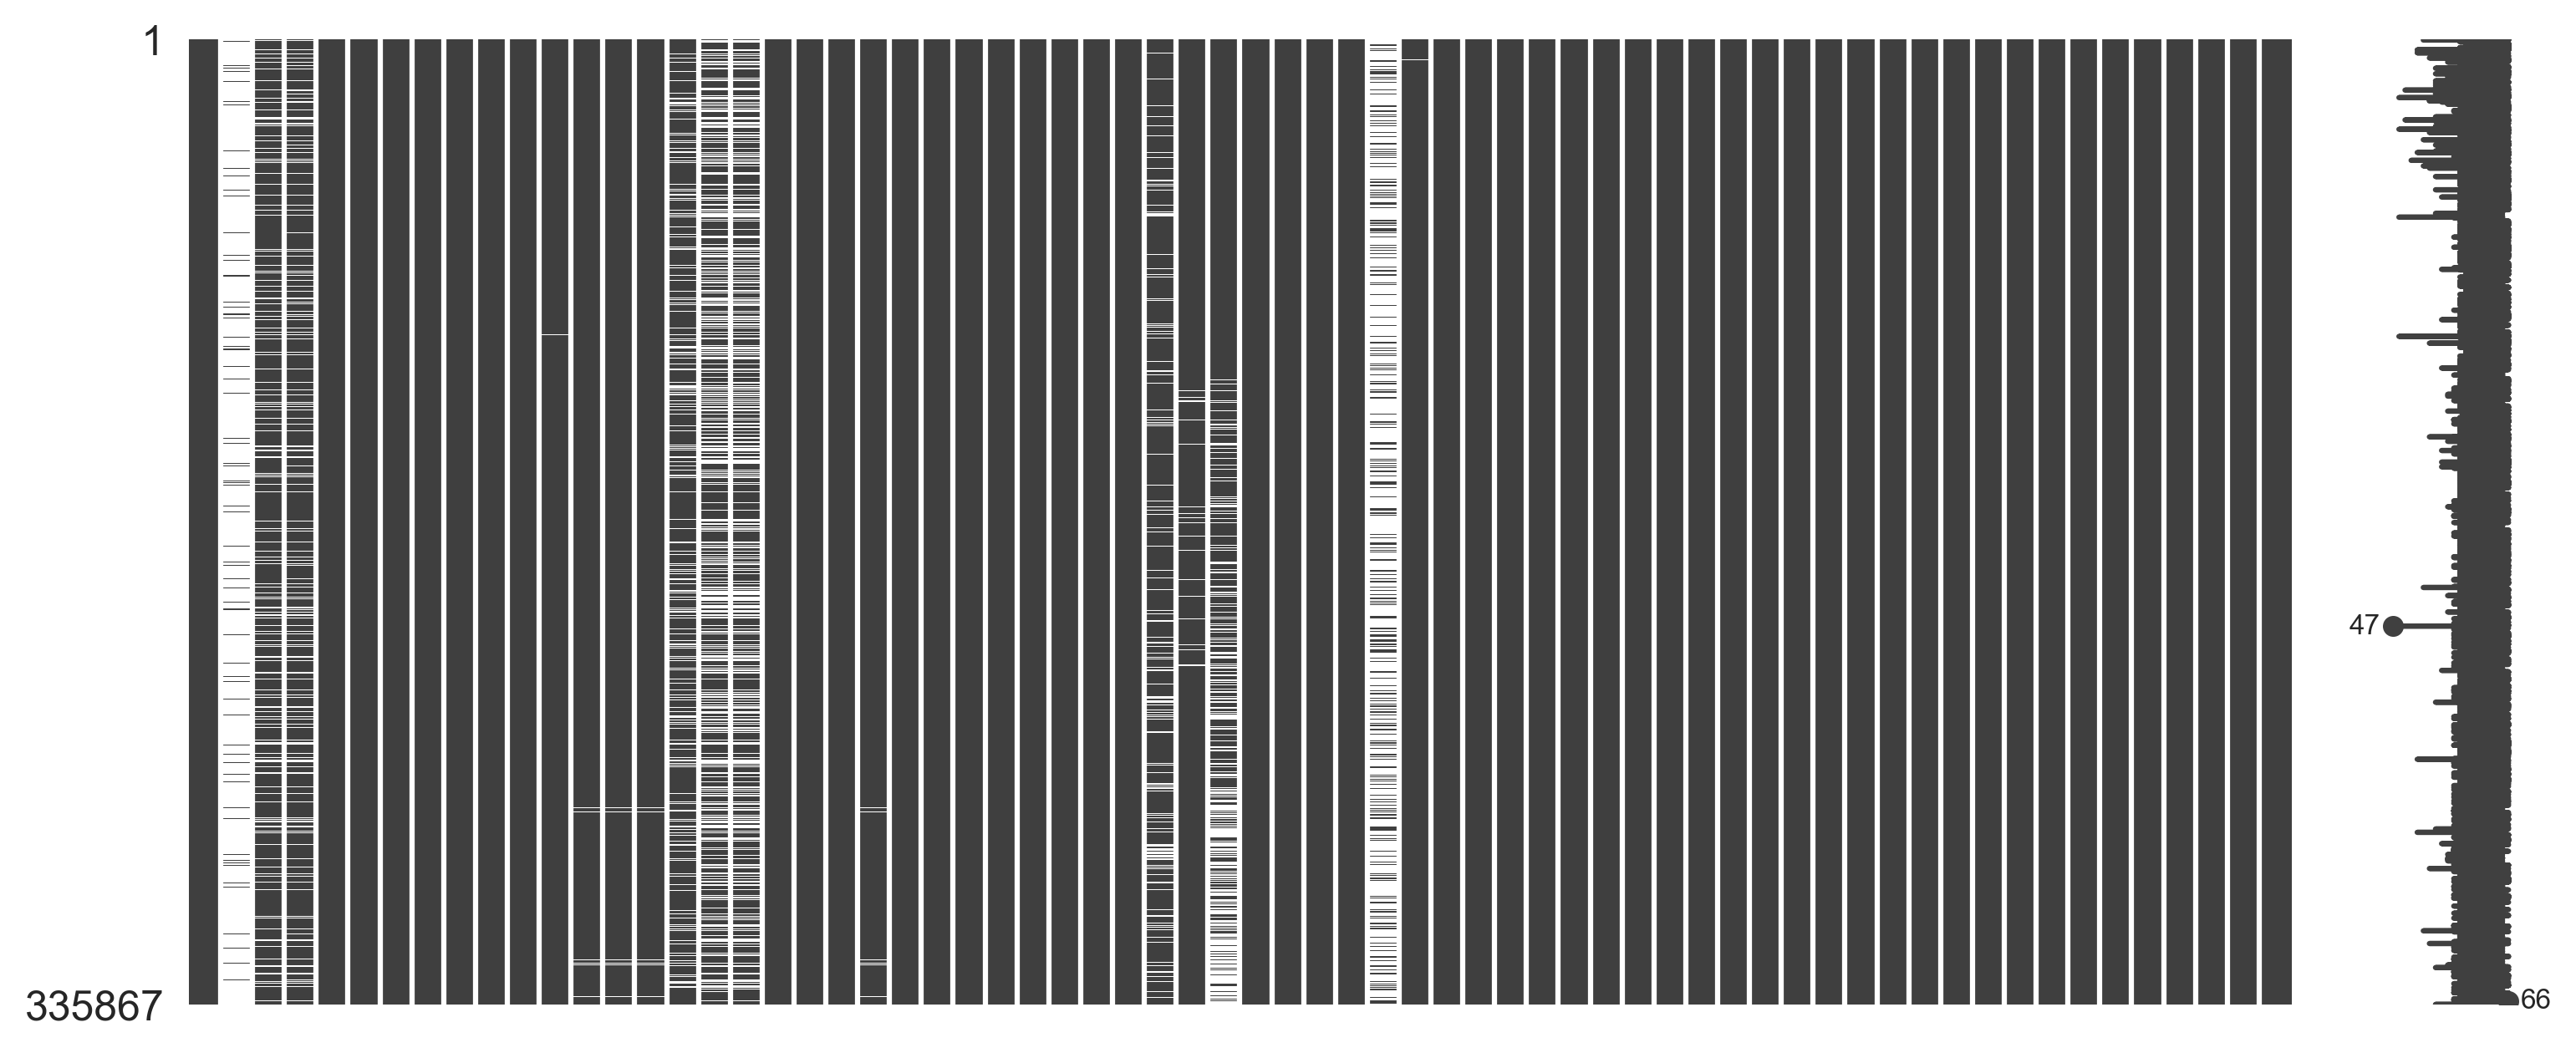

In [10]:
missingno.matrix(data,figsize=(12,5), fontsize=10)

## 4 Imputing missing data

Imputing

Overview missing data in selected features (and those needed to calculate them):
1   co2                 136 in  65 patients.
2   spo2                119 in  95 patients.
3   rmv                 358 in  112 patients.
4   respiratory_rate    358 in  112 patients.
5   systolic            2,191 in    241 patients.
6   diastolic           2,191 in    241 patients.
7   mean_art_press      2,191 in    241 patients.
8   heart_rate          2,191 in    241 patients.
9   temperature         56,694 in   5,059 patients.
10  ph                  118,903 in  5,209 patients.
11  hemoglobin          117,542 in  5,207 patients.
12  creatinine          42,010 in   708 patients.
13  pmax                358 in  112 patients.
14  peep                358 in  112 patients.
15  fio2                228 in  66 patients.

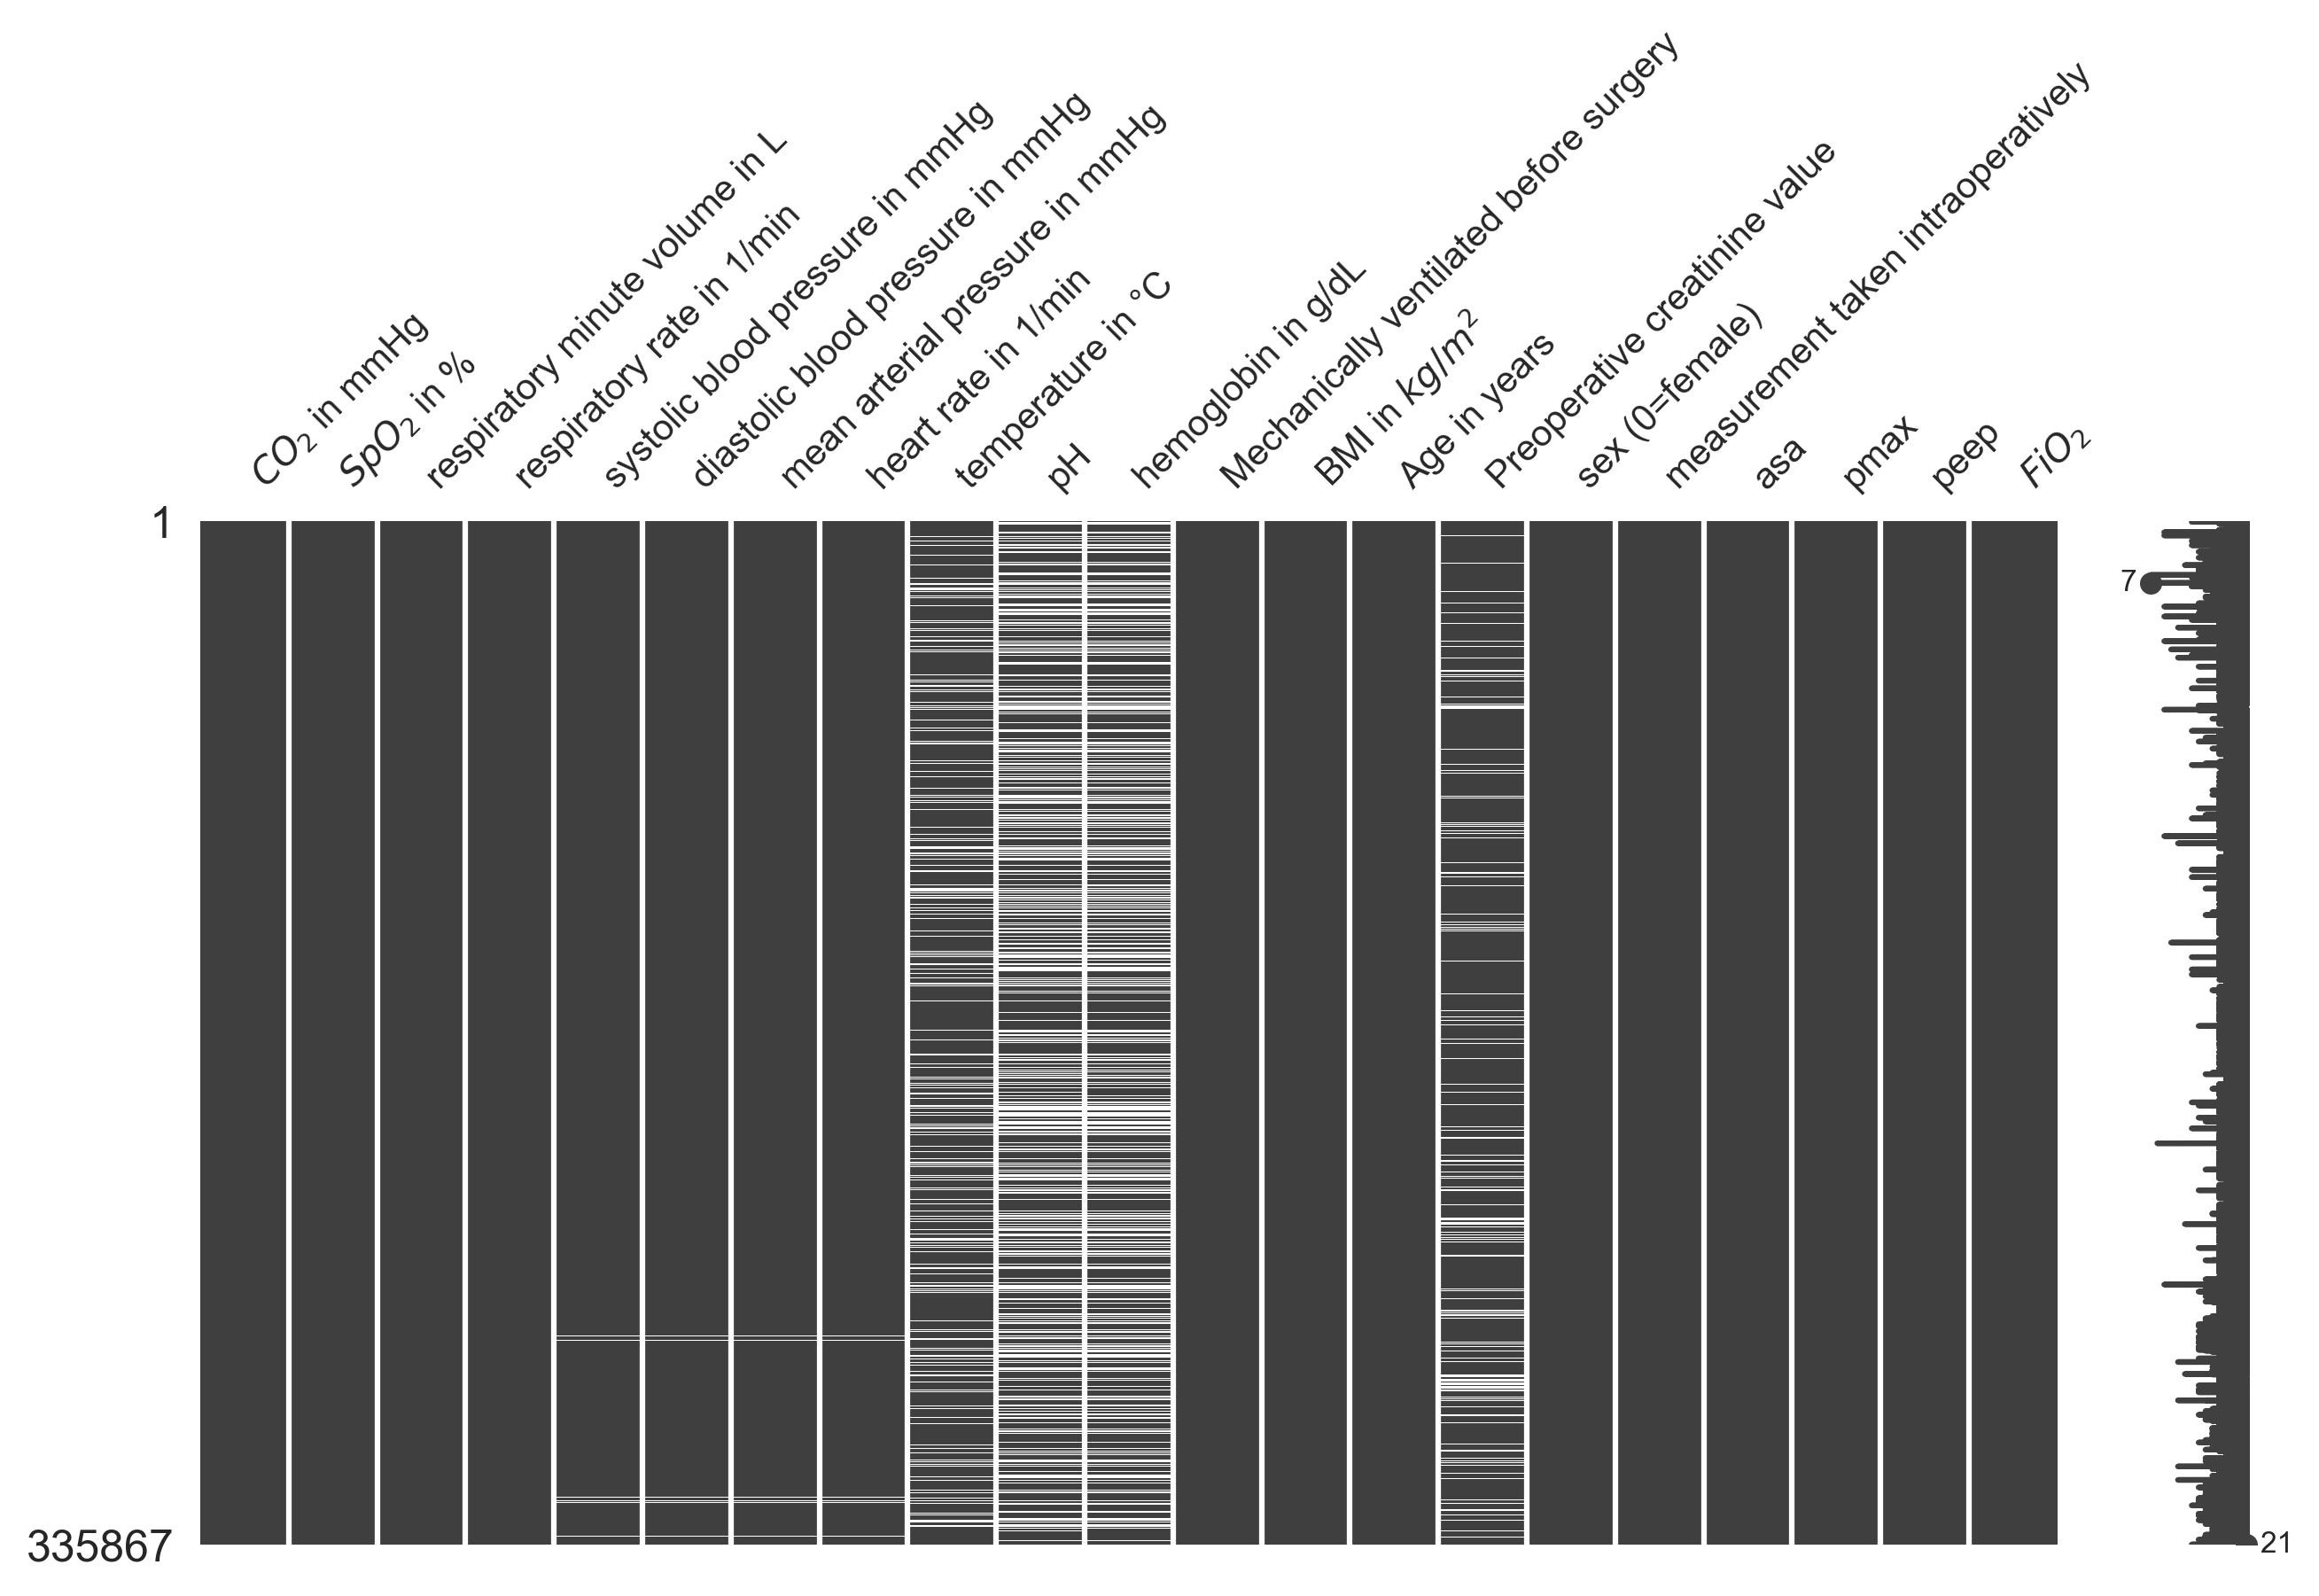

In [11]:
col_to_impute = copy.deepcopy(selected_features)
col_to_impute.extend(["pmax", "peep", "fio2"])
col_to_impute.remove("idx")
col_to_impute.remove("pAO2")
col_to_impute.remove("compliance")
col_to_impute.remove("gadrey")

missingno.matrix(data[col_to_impute].rename(columns=config.get("feature_names")),figsize=(10,5), fontsize=10)

print("Overview missing data in selected features (and those needed to calculate them):")
i = 1
for c in col_to_impute:
    if data[c].isnull().sum()>0:
        print(f"{i}\t{c.ljust(20)}{data[c].isnull().sum():,} in \t{len(data[data[c].isnull()].identifier.unique()):,} patients.")
        i+=1

# pAO2, gadrey, first_horowitz can be calculated

min_vals = []
max_vals = []
for c in col_to_impute:
    min_vals.append(min(data.loc[data[c].isnull()==False,c].values))
    max_vals.append(max(data.loc[data[c].isnull()==False,c].values))

imputed_data_path = Path(config.get('pickle').get('imputed_data'))
if imputed_data_path.exists():
    with open(imputed_data_path, 'rb') as idp:
        imputed_data = pickle.load(idp)
else:
    imp = IterativeImputer(
        max_iter=100,
        random_state=42,
        initial_strategy="median",
        min_value=min_vals,
        max_value=max_vals,
        verbose=2,
        tol=1e-4,
    )

    imputed_data = pd.DataFrame(
        imp.fit_transform(data[col_to_impute]),
        columns=col_to_impute,
    )
    with open(imputed_data_path, 'wb') as idp:
        pickle.dump(imputed_data, idp)

for c in imputed_data.columns:
    data[c] = imputed_data[c].values

# mean of imputed creatinine values
for identifier in data.identifier.unique():
    data.loc[data.identifier == identifier, "creatinine"] = np.mean(
        data.loc[data.identifier == identifier, "creatinine"]
    )

Missing data matrix (all features)

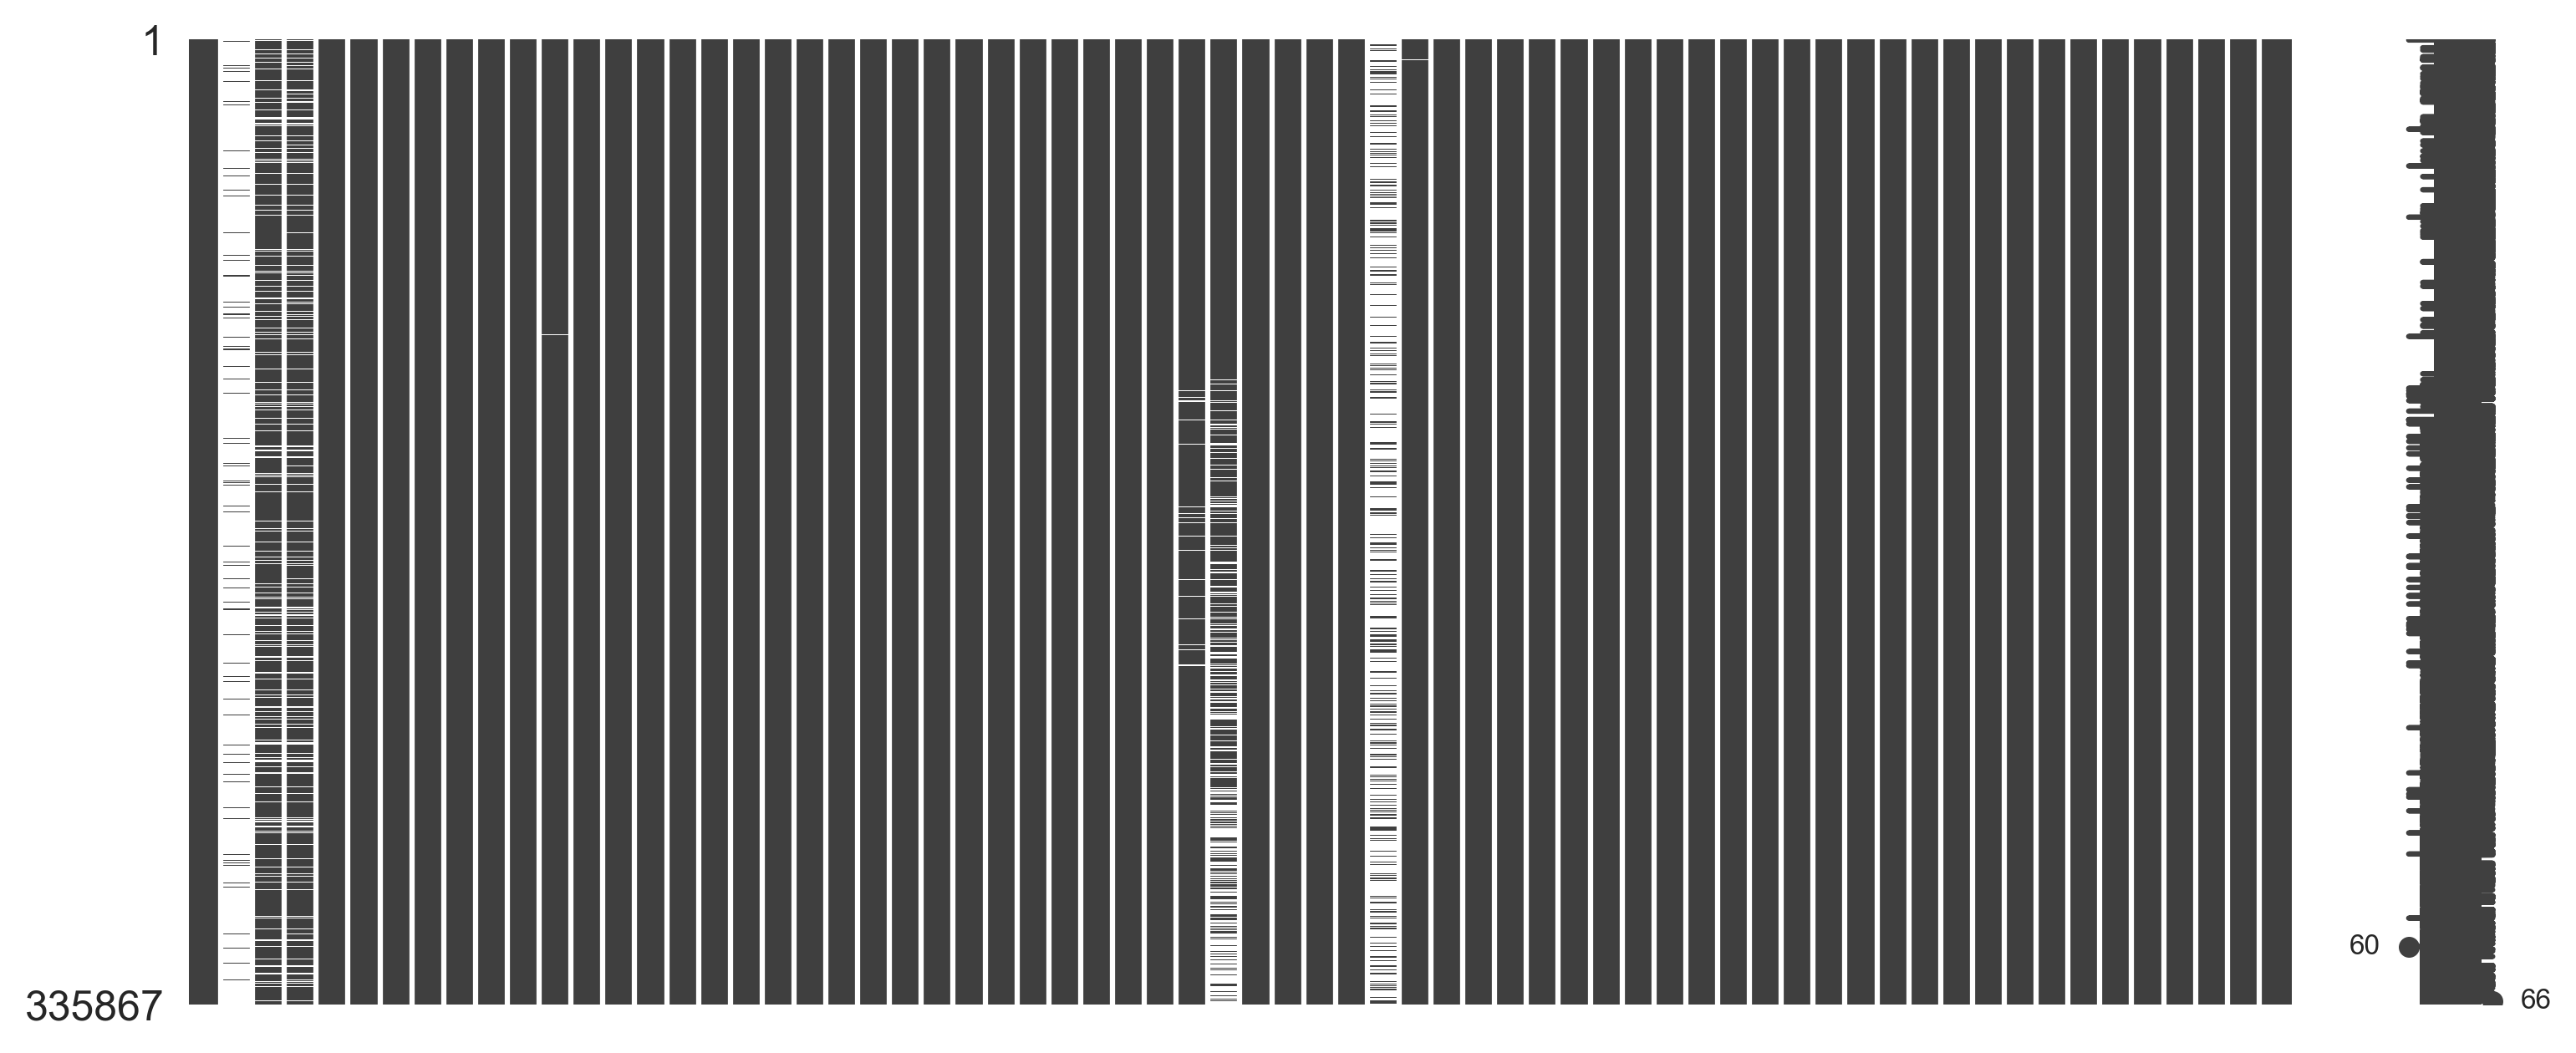

In [12]:
missingno.matrix(data,figsize=(12,5), fontsize=10)

Complete required columns pAO2, compliance and Gadrey’s paO2 with
imputed values.

In [13]:
data.loc[data.pAO2.isnull(), "pAO2"] = (data.loc[data.pAO2.isnull(), "fio2"] / 100) * (
    713.622 - 47
) - (data.loc[data.pAO2.isnull(), "co2"] / 0.82)

data.loc[data.gadrey.isnull(), "gadrey"] = (
    (28.6025) ** 3 / ((1 / (data.loc[data.gadrey.isnull(), "spo2"] / 100)) - 0.99)
) ** (1 / 3)

data.loc[
    (data["paO2_measured"].isnull()) & (data["compliance"].isnull()), "compliance"
] = (
    (
        data.loc[
            (data["paO2_measured"].isnull()) & (data["compliance"].isnull()), "rmv"
        ]
        / data.loc[
            (data["paO2_measured"].isnull()) & (data["compliance"].isnull()),
            "respiratory_rate",
        ]
    )
    * 1000
    / (
        data.loc[
            (data["paO2_measured"].isnull()) & (data["compliance"].isnull()), "pmax"
        ]
        - data.loc[
            (data["paO2_measured"].isnull()) & (data["compliance"].isnull()), "peep"
        ]
    )
)

## 5 Exclusion Criteria

In [14]:
print("\nExcluding based on cut-off values.\n\n")

# creatinine value < 0.2
total, patients = current_stats(data)
missing = len(data[data.creatinine.isnull() & (data.pao2_type_measured==0)])
print(f"Missing creatinine data points: {missing}.")
if missing > 0:
    data = data[~(data.creatinine.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & (data.creatinine<0.2))]
total3, patients3 = current_stats(data, p=True)
print(f"creatinine <0.2 mg/dL (N={patients2-patients3:,}, n={total2-total3:,})\n")


# hb value <5
total, patients = current_stats(data)
missing = len(data[data.hemoglobin.isnull() & (data.pao2_type_measured==0)])
print(f"Missing hemoglobin data points: {missing}.")
if missing > 0:
    data = data[~(data.hemoglobin.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & (data.hemoglobin<5))]
total3, patients3 = current_stats(data, p=True)
print(f"Hemoglobin value < 5g/dL (N={patients2-patients3}, n={total2-total:,})\n")


# ph value <6.8
total, patients = current_stats(data)
missing = len(data[data.ph.isnull() & (data.pao2_type_measured==0)])
print(f"Missing pH data points: {missing}.")
if missing > 0:
    data = data[~(data.ph.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & (data.ph<6.8))]
total3, patients3 = current_stats(data, p=True)
print(f"pH value < 6.8 (N={patients2-patients3}, n={total2-total3:,})\n")


# heart rate < 20
total, patients = current_stats(data)
missing = len(data[data.heart_rate.isnull() & (data.pao2_type_measured==0)])
print(f"Missing heart_rate data points: {missing}.")
if missing > 0:
    data = data[~(data.heart_rate.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & (data.heart_rate<20))]
total3, patients3 = current_stats(data, p=True)
print(f"heart rate < 20 (N={patients2-patients3}, n={total2-total3:,})\n")


# 5 <= respiratory rate >= 50
total, patients = current_stats(data)
missing = len(data[data.respiratory_rate.isnull() & (data.pao2_type_measured==0)])
print(f"Missing respiratory_rate data points: {missing}.")
if missing > 0:
    data = data[~(data.respiratory_rate.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & ((data.respiratory_rate<5) | (data.respiratory_rate>50)))]
total3, patients3 = current_stats(data, p=True)
print(f"5 <= respiratory rate >= 50/min (N={patients2-patients3}, n={total2-total3:,})\n")


# rmv < 2
total, patients = current_stats(data)
missing = len(data[data.rmv.isnull() & (data.pao2_type_measured==0)])
print(f"Missing rmv data points: {missing}.")
if missing > 0:
    data = data[~(data.rmv.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & (data.rmv<2))]
total3, patients3 = current_stats(data, p=True)
print(f"RMV < 2 L/min (N={patients2-patients3}, n={total2-total3:,})\n")


# measured temperature < 32°C and > 44°C
total, patients = current_stats(data)
missing = len(data[data.temperature.isnull() & (data.pao2_type_measured==0)])
print(f"Missing temperature data points: {missing}.")
if missing > 0:
    data = data[~(data.temperature.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & ((data.temperature<32) | (data.temperature>44)))]
total3, patients3 = current_stats(data, p=True)
print(f"temperature <32°C or >44°C (N={patients2-patients3}, n={total2-total3:,})\n")


# Compliance 10-250
total, patients = current_stats(data)
missing = len(data[data.compliance.isnull() & (data.pao2_type_measured==0)])
print(f"Missing compliance data points: {missing}.")
if missing > 0:
    data = data[~(data.compliance.isnull() & (data.pao2_type_measured==0))]
total2, patients2 = current_stats(data)
print(f"remove missing N={patients-patients2}, n={total-total2}")
data = data[~((data.pao2_type_measured==0) & ((data.compliance<10) | (data.compliance>250)))]
total3, patients3 = current_stats(data, p=True)
print(f"compliance <10 or >250 (N={patients2-patients3}, n={total2-total3:,})\n")


# Measured < 60 + SpO2 > 95 + hb > 7
total, patients = current_stats(data)
data = data[~((data.pao2_type_measured==1) & (data.paO2_measured<60) & (data.spo2>95) & (data.hemoglobin>7))]
total2, patients2 = current_stats(data, p=True)
print(f"measured paO2 < 60 mmHg + SpO2 > 95 % + hemoglobin > 7 g/dL (N={patients-patients2}, n={total-total2})\n")


Excluding based on cut-off values.


Missing creatinine data points: 0.
remove missing N=0, n=0
334,931 observations from 5,210 patients with 20,589 measured paO2 values (6.15 %).
creatinine <0.2 mg/dL (N=0, n=936)

Missing hemoglobin data points: 0.
remove missing N=0, n=0
334,648 observations from 5,210 patients with 20,589 measured paO2 values (6.15 %).
Hemoglobin value < 5g/dL (N=0, n=0)

Missing pH data points: 0.
remove missing N=0, n=0
334,648 observations from 5,210 patients with 20,589 measured paO2 values (6.15 %).
pH value < 6.8 (N=0, n=0)

Missing heart_rate data points: 0.
remove missing N=0, n=0
334,620 observations from 5,210 patients with 20,589 measured paO2 values (6.15 %).
heart rate < 20 (N=0, n=28)

Missing respiratory_rate data points: 0.
remove missing N=0, n=0
333,545 observations from 5,210 patients with 20,589 measured paO2 values (6.17 %).
5 <= respiratory rate >= 50/min (N=0, n=1,075)

Missing rmv data points: 0.
remove missing N=0, n=0
332,553 observations

Stats

In [15]:
print(
    f"Actual average number of ABG per patient: {round(len(data[data.pao2_type_measured==1])/len(data[data.pao2_type_measured==1].identifier.unique()),2)} in {int(np.mean(data[data.pao2_type_measured==1].groupby('identifier')['mv_time'].mean()))} min => one ABG every {int(np.mean(data[data.pao2_type_measured==1].groupby('identifier')['mv_time'].mean())/(len(data[data.pao2_type_measured==1])/len(data[data.pao2_type_measured==1].identifier.unique())))} minutes.\n\n"
)

Actual average number of ABG per patient: 3.89 in 346 min => one ABG every 88 minutes.



In [16]:
# display(data.groupby("identifier").sum("paO2_type_measured").sort_values("pao2_type_measured")["pao2_type_measured"])

if data.groupby("identifier").sum("paO2_type_measured").sort_values("pao2_type_measured")["pao2_type_measured"].values[0] == 0:
    print(f"There are {Counter(data.groupby('identifier').sum('paO2_type_measured').sort_values('pao2_type_measured')['pao2_type_measured'].values).get(1)} patients without any measured paO2 left. Drop these patients.")

## 6 SAP Complications

In [17]:
all_complications = []
all_complications_text = []
for comp in data.loc[data["sap_behandlungs_diagnoses"].isnull()==False, 'sap_behandlungs_diagnoses'].unique():
    if '|' in comp:
        all_complications.extend([c.split('__')[0] for c in comp.split('|')])
        all_complications_text.extend([c[0:-18].replace('None', '').replace('____', '__') for c in comp.split('|')])
    else:
        all_complications.append(comp.split('__')[0])
        all_complications_text.append(comp[0:-18].replace('None', '').replace('____', '__'))

all_complications = sorted(list(set(all_complications)))
all_complications_text = sorted(list(set(all_complications_text)))

One time allocation of complications

In [18]:
def get_complication(icd_string, complication_dict):
    for complication, code in complication_dict.items():
        if code in icd_string:
            return complication
    return None  # if no match is found

complication_codes_diagnoses = {k: [] for k in config.get("complications_dict").keys()}
no_complication = []

In [19]:
if Path('data/out/complication_codes_diagnoses.pickle').exists():
    complication_codes_diagnoses = pickle.load(open('data/out/complication_codes_diagnoses.pickle','rb'))
if Path('data/out/no_complications.pickle').exists():
    no_complication = pickle.load(open('data/out/no_complications.pickle', 'rb'))

idx=1
for complication in all_complications_text:
    complication = complication.replace('None', '').replace('____', '__')
    if idx%20==0:
        cont = input("Continue? [Y/n] ")
        if cont == 'n':
            break
    code = complication.split('__')[0]
    if any([complication in values for values in complication_codes_diagnoses.values()]):
        continue
    if complication in no_complication:
        continue
    idx += 1
    complication_str = get_complication(code, config.get("complications_dict_short"))
    if complication_str:
        correct = input(f"{complication} was identified as >>>{complication_str}<<<. Correct? [Y/n] ")
        if correct != 'n':
            complication_codes_diagnoses[complication_str].append(complication)
            pickle.dump(complication_codes_diagnoses, open('data/out/complication_codes_diagnoses.pickle','wb'))
            continue
    complication_str = input(f"{complication}: \n{config.get('complications_dict').keys()}")
    if complication_str in complication_codes_diagnoses.keys():
        complication_codes_diagnoses[complication_str].append(complication)            
        pickle.dump(complication_codes_diagnoses, open('data/out/complication_codes_diagnoses.pickle','wb'))
        continue
    no_complication.append(complication)
    pickle.dump(no_complication, open('data/out/no_complications.pickle', 'wb'))

In [20]:
for c in sorted(no_complication):
    print(c)

F05.1__Delir bei Demenz
F05.1__Delir bei Demenz__Delir bei Demenz
F05.1__Demenz mit Delirium__Delir bei Demenz
F05.1__Senile Demenz mit akuter Verwirrtheit__Delir bei Demenz
F10.4__Alkoholentzugsdelirium__Psychische und Verhaltensstörungen durch Alkohol: Entzugssyndrom mit Delir
F10.4__Psychische und Verhaltensstörungen durch Alkohol: Entzugssyndrom mit Delir
F10.4__Psychische und Verhaltensstörungen durch Alkohol:__Psychische und Verhaltensstörungen durch Alkohol: Entzugssyndrom mit Delir
F10.4__entzugsdelir bei C2 Abusus__Psychische und Verhaltensstörungen durch Alkohol: Entzugssyndrom mit Delir
F11.4__Psychische und Verhaltensstörungen durch Opioide: Entzugssyndrom mit Delir
F11.4__Psychische und Verhaltensstörungen durch Opioide:__Psychische und Verhaltensstörungen durch Opioide: Entzugssyndrom mit Delir
F17.4__Psychische und Verhaltensstörungen durch Tabak: En__Psychische und Verhaltensstörungen durch Tabak: Entzugssyndrom mit Delir
F19.4__Drogenentzugssyndrom mit Delirium__Psychi

In [21]:
with open('data/out/no_postop_complications.txt', 'w') as f:
    for entry in no_complication:
        f.write(f"{entry}\n")

with open('data/out/identified_postop_complications.txt', 'w') as f:
    for complication, codes in complication_codes_diagnoses.items():
        f.write(f"{complication}\n")
        for code in codes:
            f.write(f"\t{code}\n")

Pivot complications into one columns each

In [22]:
for comp, codes in config.get("complications_dict").items():
    data[comp] = data["sap_behandlungs_diagnoses"].str.contains("|".join(codes), case=False, na=False)
    data[comp] = data[comp].astype(bool)

data = data.drop('sap_behandlungs_diagnoses', axis=1)

## 7 SAP Diagnoses

In [23]:
data['epilepsy'] = False
codes = ['G40']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'epilepsy'] = True


data['trigeminus'] = False
codes = ['G50', 'G51']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'trigeminus'] = True


data['benign_neoplasm'] = False
codes = ['D1', 'D2', 'D3']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'benign_neoplasm'] = True


data['neoplasm'] = False
codes = ['D37', 'D38', 'D39', 'D4']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'neoplasm'] = True


data['malignant_neoplasm'] = False
codes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'malignant_neoplasm'] = True


data['other_aneurysm_dissection'] = False
codes = ['I71', 'I72', 'I77']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'other_aneurysm_dissection'] = True


data['TBI'] = False
codes = ['S01', 'S02', 'S03', 'S04', 'S06', 'S07', 'S08', 'S09']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'TBI'] = True


data['intracranial_hemorrhage'] = False
codes = ['I62', 'I61']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'intracranial_hemorrhage'] = True


data['cerebral_aneurysm'] = False
codes = ['I67.1']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'cerebral_aneurysm'] = True


data['SAH'] = False
codes = ['I60']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'SAH'] = True


# data['intracerebral_hemorrhage'] = False
# codes = ['I61']
# mask = (data['sap_op_diagnosis']
#     .apply(
#     lambda val: False if pd.isna(val) 
#     else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
# ))
# data.loc[mask,'intracerebral_hemorrhage'] = True


data['ischaemic_stroke'] = False
codes = ['I63']
mask = (data['sap_op_diagnosis']
    .apply(
    lambda val: False if pd.isna(val) 
    else any(any(x.startswith(code) for code in codes) for x in val.split("|"))
))
data.loc[mask,'ischaemic_stroke'] = True


data.loc[:,'other'] = False
data.loc[data[config.get('diagnoses')].sum(axis=1)==0,'other']=True


current_stats(data, p = True)
# Compute per-identifier sum of diagnoses for ischemic stroke patients
counts = (
    data.loc[data.ischaemic_stroke == True]
    .groupby("identifier")[config.get('diagnoses')]
    .sum()
    .apply(np.sum, axis=1)
)
# Count how many identifiers have >1 diagnosis
num_multiple = (counts > 1).sum()

print(f"Number of patients with ischaemic stroke (N={data.loc[data.ischaemic_stroke==True].groupby('identifier').count().shape[0]}) and at least one other diagnosis: {num_multiple}.")
data = data[data.ischaemic_stroke == False]
current_stats(data, p = True)

data = data.drop('ischaemic_stroke', axis = 1)



data = data.drop(['diagnosis', 'sap_op_diagnosis'], axis = 1)

330,818 observations from 5,210 patients with 20,290 measured paO2 values (6.13 %).
Number of patients with ischaemic stroke (N=88) and at least one other diagnosis: 15.
326,933 observations from 5,122 patients with 20,014 measured paO2 values (6.12 %).

## 8 Discharge Type

In [24]:
data["deceased"] = False 
data.loc[data["discharge_type"].isin(["HT", "T"]),"deceased"] = True 
data = data.drop("discharge_type", axis = 1)

dump data

In [25]:
with open("data/out/data_ready.pickle", "wb") as d:
    pickle.dump(data, d)

## 9 Preparing for prediction

datasets for prediction before and after first abg.

Fitting scaler for x and y

In [26]:
complete_cases = data.loc[:,selected_features + ["last_horowitz", "identifier", "paO2_measured"]].dropna()
complete_identifiers = complete_cases["identifier"].values.reshape(-1, 1)

y_train = complete_cases["paO2_measured"].values.reshape(-1, 1)
complete_cases = complete_cases.drop(columns=["identifier", "paO2_measured"])

x_train = complete_cases.values
x_train = np.where(np.isinf(x_train), np.nan, x_train)

valid_mask = ~np.isnan(x_train).any(axis=1)
x_train = x_train[valid_mask]
y_train = y_train[valid_mask]
complete_identifiers = complete_identifiers[valid_mask]


# Initialize and fit scaler for X (features)
scaler_x_lh = preprocessing.MinMaxScaler()
x_train_scaled = scaler_x_lh.fit_transform(x_train)

scaler_x = preprocessing.MinMaxScaler()
scaler_x.fit(x_train[:,:-1])

with open(Path(config["pickle"]["scaler_x_lh"]), "wb") as sx:
    pickle.dump(scaler_x_lh, sx)

with open(Path(config["pickle"]["scaler_x"]), "wb") as sx:
    pickle.dump(scaler_x, sx)

# Initialize and fit scaler for y (target)
scaler_y = preprocessing.MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

with open(Path(config["pickle"]["scaler_y"]), "wb") as sy:
    pickle.dump(scaler_y, sy)

train_data = {
    "x": x_train,  # original (unscaled) features
    "x_scaled": np.hstack((complete_identifiers, x_train_scaled)),  # scaled features + IDs
    "y_scaled": np.hstack((complete_identifiers, y_train_scaled)),  # scaled target + IDs
    "y": y_train,  # original target values
    "identifiers": complete_identifiers,  # just the subject IDs
}